## **Сервис прогнозирования отмены в системе интернет-бронирования отелей**

Сначала мы попытаемся ответить на следующие вопросы
1. Сколько бронирований было отменено?
2. Каково соотношение бронирований между курортными и городскими отелями?
3. Каков процент бронирования за каждый год?
4. Какой месяц является наиболее загруженным для отеля?
5. Из какой страны приезжает больше всего гостей?
6. Как долго люди останавливаются в гостинице?
7. Какой тип размещения был забронирован чаще всего (одиночный, парный, семейный)?

После этого мы создадим прогностическую модель, чтобы предсказать, будет ли бронирование отменено или нет.

## Импортируем библиотеки


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC

pd.options.display.max_columns = None

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Импортируем данные
data = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/hotel_bookings.csv')
# Задаем точки разбиения
split_points = [90000, 100000]

`split_points = [90000, 100000]`

`split_points` — это точки разбиения данных на обучающее, тестовое и валидационное множества при учете времени. на самом деле там пропорции немного другие должны быть по хорошему. я просто размеры множества крутил туда сюда, просто так поставил. они сильно не должны на результат повлиять. вообще рекомендуют 60% 20% 20% (training, validation and test sets in the ratio 60:20:20)

In [4]:
# Обрежем данные
data = data.sample(frac=1)[:4000]
split_points = [2000, 3000]

**обратите внимание, что при закомментировании этой ячейки кода модели будут строиться на основе полного объема данных**

поскольку после добавления `SVM` код модели выполняется слишком долго, добавил эту ячейку кода, чтобы уменьшить объем данных, используемых для построения моделей машинного обучения в экспериментальных целях

* `data.sample(frac=1)` — перемешивает data и берет заданную часть, в данном случае все данные `(frac=1)`
* `[:4000]` — берет первые 4000 строк
* `split_points = [2000, 3000]` — просто переопределяю точки разбиения

In [5]:
# Функция для определения номера месяца по названию
def monthOrder(month):
  month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
  return month_order.index(month)
# Добавляем столбец для сортировки по месяцу
data['month_order'] = data.apply(lambda row: monthOrder(row['arrival_date_month']), axis=1)
# Сортируем данные
data.sort_values(by = ['arrival_date_year', 'month_order', 'arrival_date_day_of_month']  , axis=0, inplace=True)

In [6]:
# Показажем первые 5 строк данных
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,month_order
20,Resort Hotel,0,37,2015,July,27,1,1,4,1,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,F,F,0,No Deposit,241.0,NaN,0,Transient,97.29,0,1,Check-Out,06-07-15,6
74973,City Hotel,1,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,1,0,A,A,0,No Deposit,6.0,NaN,0,Transient,101.50,0,0,Canceled,16-06-15,6
15298,Resort Hotel,0,181,2015,July,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,D,E,0,No Deposit,240.0,NaN,0,Transient,153.00,0,1,Check-Out,05-07-15,6
27,Resort Hotel,1,60,2015,July,27,1,2,5,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,240.0,NaN,0,Transient,107.00,0,2,Canceled,11-05-15,6
15351,Resort Hotel,0,152,2015,July,27,2,2,5,1,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,243.0,NaN,0,Contract,60.35,0,2,Check-Out,09-07-15,6


<hr>

## Предварительная обработка данных

In [7]:
# Скопируем набор данных
df = data.copy()

### 1. Работа с отсутствующими значениями

In [8]:
# Найдите пропущенное значение, покажите общее количество пропущенных значений 
# для каждого столбца и отсортируем их в порядке убывания
df.isnull().sum().sort_values(ascending=False)[:10]

company                           3761
agent                              557
country                             14
children                             1
hotel                                0
assigned_room_type                   0
booking_changes                      0
deposit_type                         0
days_in_waiting_list                 0
previous_bookings_not_canceled       0
dtype: int64

In [9]:
# Удалим строки, в которых нет взрослых, детей и младенцев
df = df.drop(df[(df.adults+df.babies+df.children)==0].index)


# Если идентификатор агента или компании не равен нулю, просто заменим его на 0
df[['agent','company']] = df[['agent','company']].fillna(0.0)


# Для отсутствующих значений в столбце "country" заменим его "OTHER"
df['country'].fillna("OTHER", inplace=True)


# Для отсутствующего значения детей, заменим его округленным средним значением
df['children'].fillna(round(data.children.mean()), inplace=True)

### 2. Преобразование типа данных

In [10]:
# Преобразуем тип данных этих столбцов из float в integer
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')

In [11]:
df[['children', 'company', 'agent']]

,children,company,agent
20,0,0,241
74973,0,0,6
15298,0,0,240
27,0,0,240
15351,0,0,243
...,...,...,...
73697,0,0,9
39962,0,0,250
73706,0,0,9
40032,0,0,40


In [12]:
# Проверим, изабились ли от всех null значений
df.isnull().sum().sort_values(ascending=False)[:10]

hotel                          0
previous_cancellations         0
reservation_status_date        0
reservation_status             0
total_of_special_requests      0
required_car_parking_spaces    0
adr                            0
customer_type                  0
days_in_waiting_list           0
company                        0
dtype: int64

## EDA

In [13]:
def get_count(series, limit=None):
    
    '''
    Args:
        series: series Pandas (один столбец из фрейма данных)
        limit: Если задано значение, ограничить выходное значение первыми предельными выборками.
    Returns:
        x = Уникальные значения
        y = Количество уникальных значений
    '''
    
    if limit != None:
        series = series.value_counts()[:limit]
    else:
        series = series.value_counts()
    
    x = series.index
    y = series/series.sum()*100
    
    return x.values,y.values

In [14]:
def plot(x, y, x_label=None, y_label=None, title=None, figsize=None, plot_type='bar'):
    '''
    Построим график с указанными данными x и y.

    Args:
        x (в виде массива): Данные по оси x.
        y (массив-подобный): Данные оси y.
        x_label (str, необязательно): Метка оси x.
        y_label (str, необязательно): Метка оси y.
        title (str, необязательно): Заголовок графика.
        figsize (кортеж, необязательно): Размер графика в дюймах.
        plot_type (str, необязательно): Тип графика для создания ("bar" или "line").

    Returns:
        matplotlib.Axes: Объект оси графика.
    '''
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if figsize is not None:
        plt.figure(figsize=figsize)
    
    if plot_type == 'bar':
        ax = sns.barplot(x=x, y=y)
    elif plot_type == 'line':
        ax = sns.lineplot(x=x, y=y)
    else:
        raise ValueError(f"Недопустимый тип '{plot_type}'. Ожидается 'bar' или 'line'.")
    
    if x_label is not None:
        ax.set_xlabel(x_label)
    
    if y_label is not None:
        ax.set_ylabel(y_label)
    
    if title is not None:
        ax.set_title(title)
    
    return ax

### Теперь попробуем ответить на вопросы, которые задали выше

### 1. Сколько бронирований было отменено?

<Axes: xlabel='Бронирование отменено (Нет = 0, Да = 1)', ylabel='Бронирование (%)'>

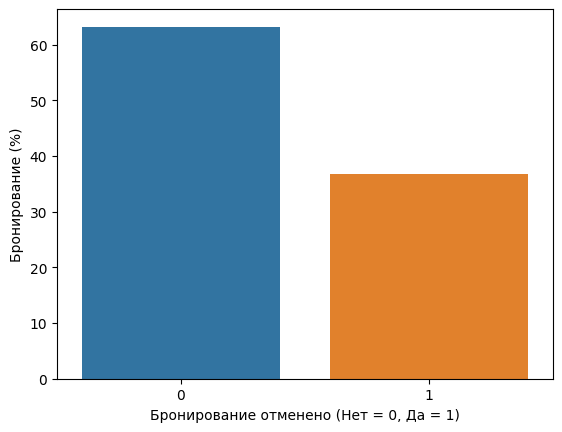

In [15]:
x, y = get_count(df['is_canceled'])
plot(x, y, x_label='Бронирование отменено (Нет = 0, Да = 1)', y_label='Бронирование (%)')

Для дальнейшего анализа выберем только те бронирования, которые не были отменены.

In [16]:
df_not_canceled = df[df['is_canceled'] == 0]

### 2. Каково соотношение бронирований между курортными и городскими отелями?

<Axes: title={'center': 'Сравнение отелей'}, xlabel='Отели', ylabel='Общее бронирование (%)'>

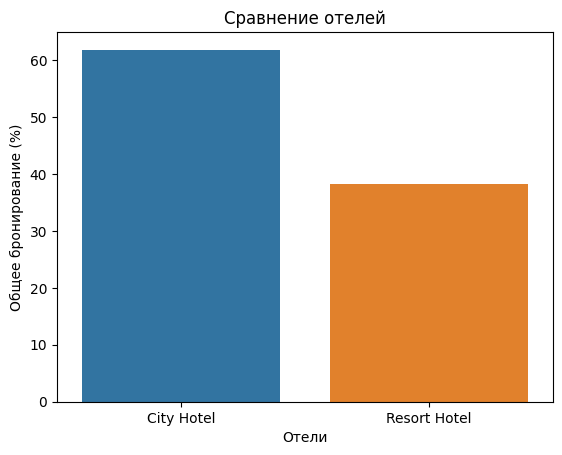

In [17]:
x,y = get_count(df_not_canceled['hotel'])
plot(x,y, x_label='Отели', y_label='Общее бронирование (%)', title='Сравнение отелей')

### 3. Каков процент бронирования за каждый год?

<Axes: title={'center': 'Сравнение по годам'}, xlabel='Год', ylabel='Общее бронирование (%)'>

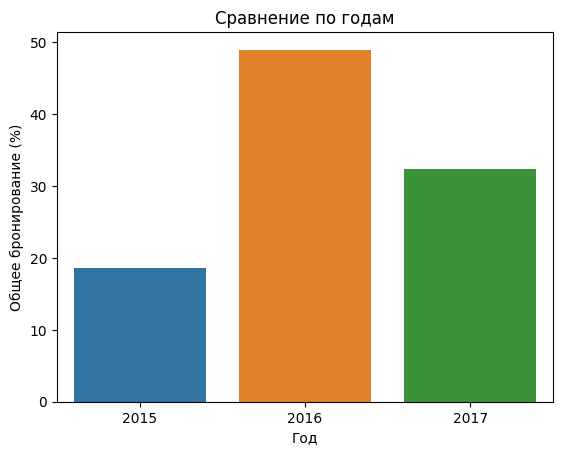

In [18]:
x,y = get_count(df_not_canceled['arrival_date_year'])
plot(x,y, x_label='Год', y_label='Общее бронирование (%)', title='Сравнение по годам')

Разделим их по отелям

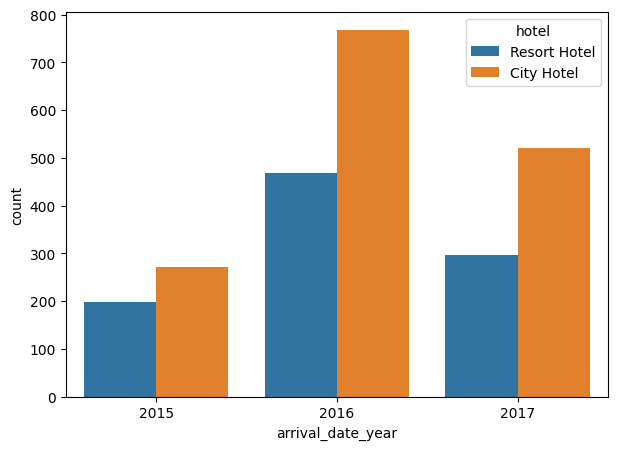

In [19]:
plt.subplots(figsize=(7,5))
sns.countplot(x='arrival_date_year', hue='hotel',  data=df_not_canceled);

### 4. Какой месяц является наиболее загруженным для отеля?

<Axes: title={'center': 'Тенденция бронирования (ежемесячно)'}, xlabel='Месяцы', ylabel='Бронирование (%)'>

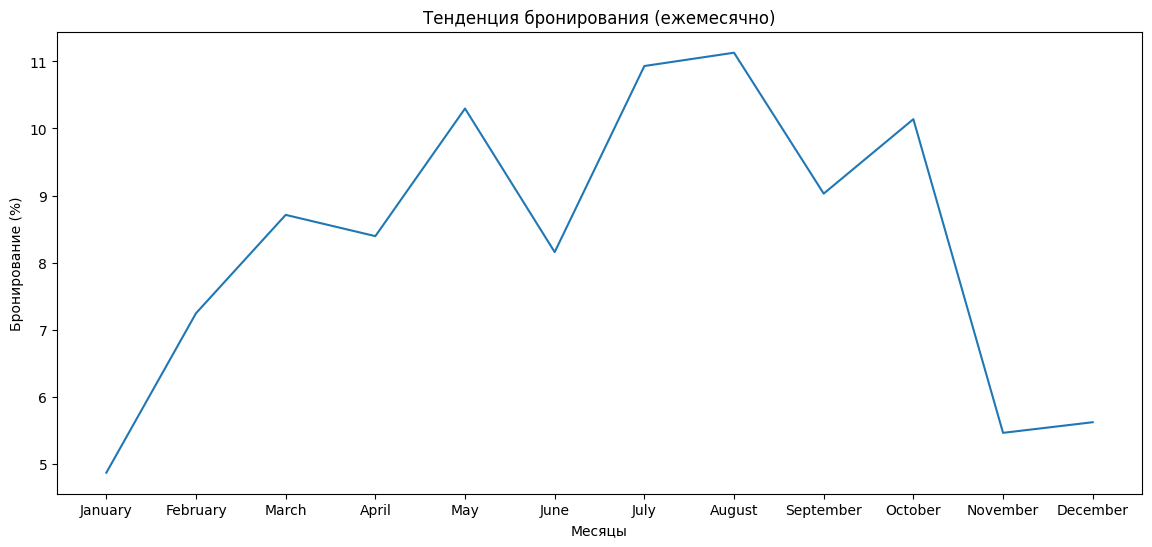

In [20]:
# Порядок месяцев
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

sorted_months = df_not_canceled['arrival_date_month'].value_counts().reindex(new_order)

x = sorted_months.index
y = sorted_months/sorted_months.sum()*100

plot(x, y.values, x_label='Месяцы', y_label='Бронирование (%)', title='Тенденция бронирования (ежемесячно)', plot_type='line', figsize=(14,6))

<Axes: title={'center': 'Тенденция бронирования (ежемесячно)'}, xlabel='Месяцы', ylabel='Бронирование (%)'>

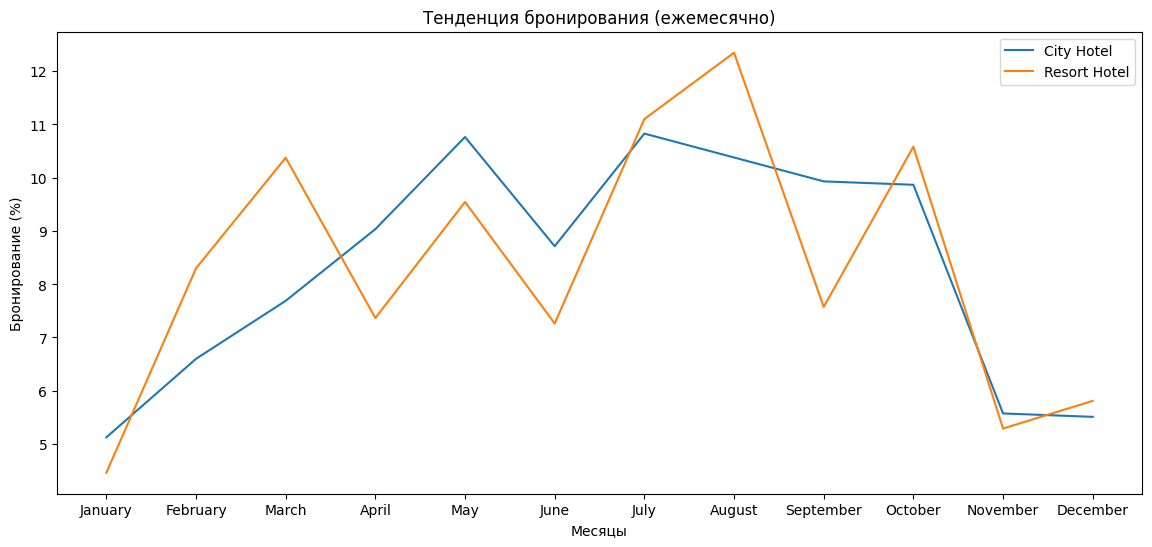

In [21]:
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Выберем только городской отель
sorted_months = df_not_canceled.loc[df_not_canceled.hotel=='City Hotel' ,'arrival_date_month'].value_counts().reindex(new_order)

x1 = sorted_months.index
y1 = sorted_months/sorted_months.sum()*100

# Выберем только курортный отель
sorted_months = df_not_canceled.loc[df_not_canceled.hotel=='Resort Hotel' ,'arrival_date_month'].value_counts().reindex(new_order)

x2 = sorted_months.index
y2 = sorted_months/sorted_months.sum()*100


# Построим линейный график
fig, ax = plt.subplots(figsize=(14, 6))

ax.set_xlabel('Месяцы')
ax.set_ylabel('Бронирование (%)')
ax.set_title('Тенденция бронирования (ежемесячно)')

sns.lineplot(x=x1, y=y1.values, label='City Hotel', ax=ax)
sns.lineplot(x=x2, y=y2.values, label='Resort Hotel', ax=ax)

### 5. Из какой страны приезжает больше всего гостей?

**`pycountry`** — очень полезный пакет Python.  
Мы будем использовать этот пакет для получения названий стран из кодов стран

In [22]:
!pip install pycountry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Axes: title={'center': 'Сравнение по странам'}, xlabel='Страны', ylabel='Общее бронирование (%)'>

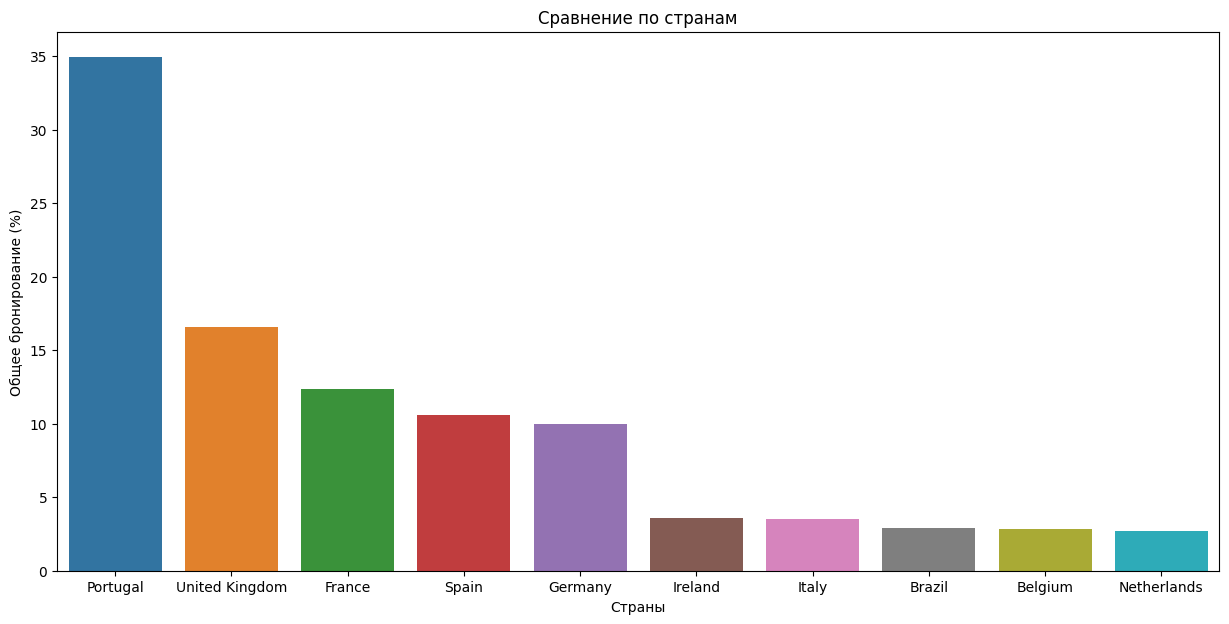

In [23]:
import pycountry as pc

x,y = get_count(df_not_canceled['country'], limit=10)

# Для каждого кода страны выберите название страны
country_name = [pc.countries.get(alpha_3=name).name for name in x]

plot(country_name,y, x_label='Страны', y_label='Общее бронирование (%)', title='Сравнение по странам', figsize=(15,7))

### 6. Как долго люди останавливаются в гостинице?

<Axes: title={'center': 'Продолжительность пребывания (Топ-10)'}, xlabel='Количество ночей', ylabel='Процент бронирования (%)'>

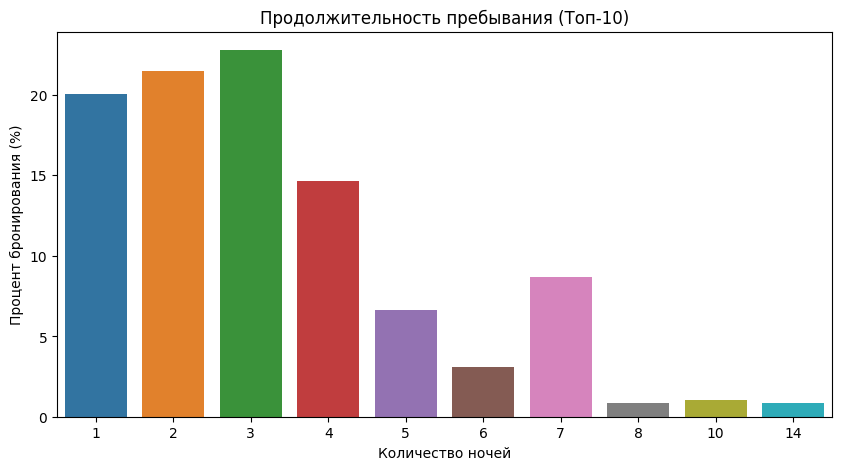

In [24]:
total_nights = df_not_canceled['stays_in_weekend_nights']+ df_not_canceled['stays_in_week_nights']
x,y = get_count(total_nights, limit=10)

plot(x,y, x_label='Количество ночей', y_label='Процент бронирования (%)', title='Продолжительность пребывания (Топ-10)', figsize=(10,5))

<Axes: title={'center': 'Продолжительность пребывания в отеле (Топ-10)'}, xlabel='total_nights', ylabel='count'>

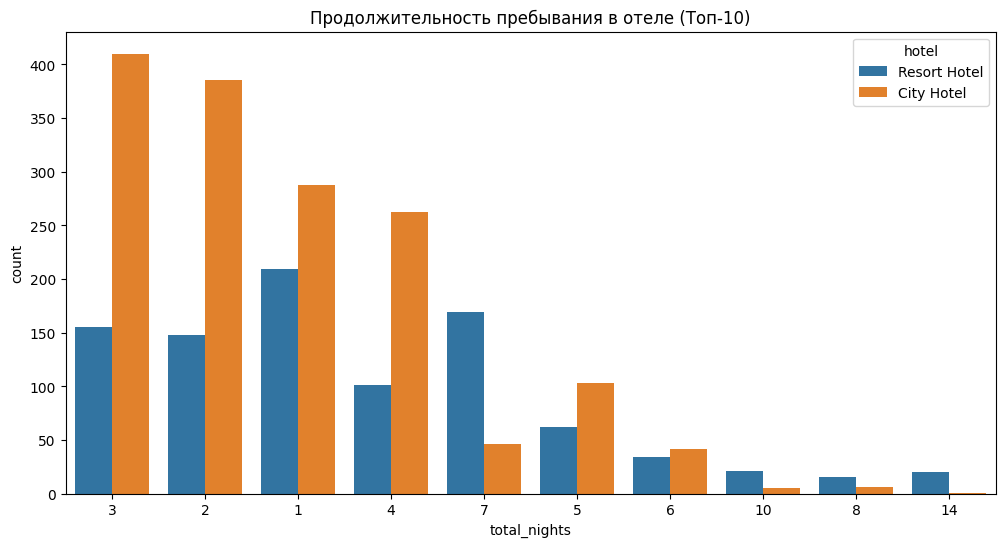

In [25]:
df_not_canceled_new = df_not_canceled.copy()
df_not_canceled_new.loc[:, 'total_nights'] = df_not_canceled_new.loc[:, 'stays_in_weekend_nights'] + df_not_canceled_new.loc[:, 'stays_in_week_nights']

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('Количество ночей')
ax.set_ylabel('Количество бронирований')
ax.set_title('Продолжительность пребывания в отеле (Топ-10)')
sns.countplot(x='total_nights', hue='hotel', data=df_not_canceled_new,
              order=df_not_canceled_new.total_nights.value_counts().iloc[:10].index, ax=ax)

### 7. Какой тип размещения был забронирован чаще всего (одиночный, парный, семейный)?

<Axes: title={'center': 'Тип размещения'}, ylabel='Бронирование (%)'>

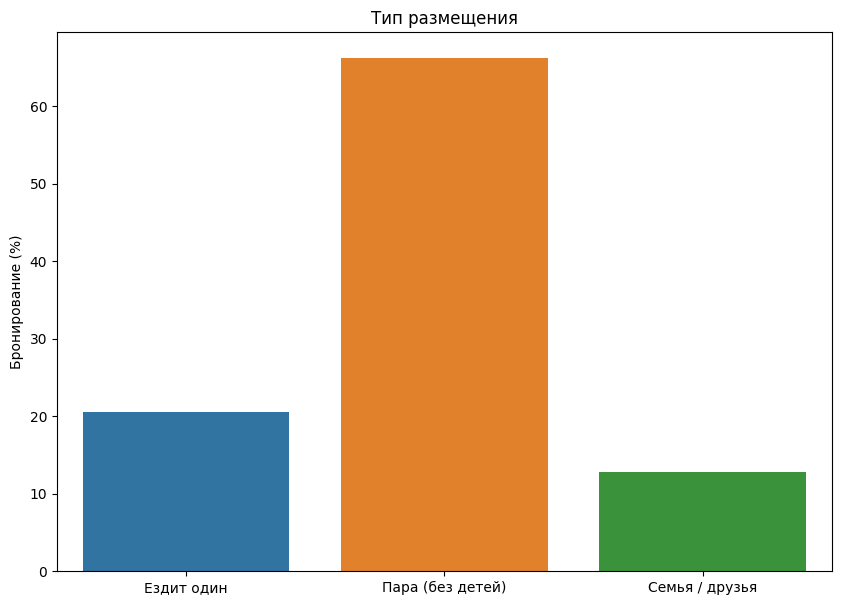

In [26]:
# Выберем кто ездит один, пару и семью
single   = df_not_canceled[(df_not_canceled.adults==1) & (df_not_canceled.children==0) & (df_not_canceled.babies==0)]
couple   = df_not_canceled[(df_not_canceled.adults==2) & (df_not_canceled.children==0) & (df_not_canceled.babies==0)]
family   = df_not_canceled[df_not_canceled.adults + df_not_canceled.children + df_not_canceled.babies > 2]

# Составим список названий категорий и их общего процента
names = ['Ездит один', 'Пара (без детей)', 'Семья / друзья']
count = [single.shape[0],couple.shape[0], family.shape[0]]
count_percent = [x/df_not_canceled.shape[0]*100 for x in count]

plot(names,count_percent,  y_label='Бронирование (%)', title='Тип размещения', figsize=(10,7))

Для дальнейшего анализа необходимо выяснить, является ли существенной информация о предыдущих отменах бронирования.

1. Определим, какова доля отмен бронирования для клиентов, которые уже отменяли бронирования ранее.
2. Сравним ее с таким же показателем, но для клиентов, которые не отменяли бронирование но хотя бы раз бронировали отель ранее.

In [27]:
df_canceled = df[df['previous_cancellations'] > 0]
df_canceled.groupby('is_canceled').size() / len(df_canceled)

is_canceled
0    0.07489
1    0.92511
dtype: float64

In [28]:
df_not_canceled_before = df[(df['previous_cancellations'] == 0) & (df['previous_bookings_not_canceled'] > 0)]
df_not_canceled_before.groupby('is_canceled').size() / len(df_not_canceled_before)

is_canceled
0    0.98
1    0.02
dtype: float64

Видим, что более чем в 90% случаев, клиенты, которые отменяли бронирование ранее, отменяют его снова. В то время как для тех клиентов, которые ни разу не отменяли бронирование эта вероятность чуть более 2%. Очевидно, что это важный показатель, который нельзя сбрасывать о счетов.

<hr>

## Feature Selection и Feature Engineering

In [29]:
# Скопируем датасет
df_subset = df.copy()

In [30]:
# Удалите колонку booking_status
# потому что она сообщает нам, было ли бронирование отменено
df_subset = df_subset.drop(['reservation_status'], axis=1)

In [31]:
# Создаем новый столбец, который содержит 1, если гость получил тот же номер, который был зарезервирован, иначе 0
df_subset['Room'] = 0
df_subset.loc[ df_subset['reserved_room_type'] == df_subset['assigned_room_type'] , 'Room'] = 1

## Создаем новый столбец, который будет содержать 1, если гость отменил больше бронирований в прошлом
## чем количество бронирований, которые он не отменял, в противном случае 0

df_subset['net_cancelled'] = 0
df_subset.loc[ df_subset['previous_cancellations'] > df_subset['previous_bookings_not_canceled'] , 'net_cancelled'] = 1

In [32]:
# На основании характеристик previous_cancellations и previous_bookings_not_canceled создадим новую характеристику - процент отмен
df_subset['cancellation_ratio'] = np.where(df_subset['previous_cancellations'] + df_subset['previous_bookings_not_canceled'] > 0,
                                           df_subset['previous_cancellations'] / (df_subset['previous_cancellations'] + df_subset['previous_bookings_not_canceled']),
                                           0)

После проведения исследовательского анализа данных (EDA), мы решили удалить следующие менее важные характеристики из набора данных:

`arrival_date_year`, `arrival_date_week_number`, `arrival_date_day_of_month`, и `arrival_date_month`: Удаляем эти признаки, потому что они представляют дату прибытия с различными уровнями детализации

`assigned_room_type` и `reserved_room_type`: Эти две характеристики представляют тип назначенного и зарезервированного номера. Они часто коррелируют, и удаление одного из них поможет уменьшить мультиколлинеарность в наших данных

`reservation_status_date`: Удаляем этот признак, так как он описывает дату обновления статуса бронирования и имеет слабую связь с отменой бронирования.

Удаление этих менее важных характеристик позволит нам сосредоточиться на наиболее важных факторах, которые влияют на отмену бронирования, улучшить производительность модели и упростить интерпретацию результатов.

In [33]:
# Удалим менее важные фичи
df_subset = df_subset.drop(['arrival_date_week_number','assigned_room_type','reserved_room_type','reservation_status_date'],axis=1)

Еще раз просмотрим количественный состав по странам

In [34]:
df_subset['country'].value_counts()[:10]

PRT    1639
GBR     428
FRA     319
ESP     273
DEU     238
ITA     119
IRL     101
BRA      79
BEL      71
USA      68
Name: country, dtype: int64

Видим, что наибольший вклад вносят первые 5 стран. Объединим остальные страны в одну категорию `OTHER`.

In [35]:
countries = df_subset['country'].value_counts()[:5].keys().to_list()

In [36]:
df_subset['country_group'] = np.where(df_subset['country'].isin(countries),
                                           df_subset['country'],
                                           "OTHER")

Удалим лишнюю характеристику `country`.

In [37]:
df_subset = df_subset.drop(['country'],axis=1)

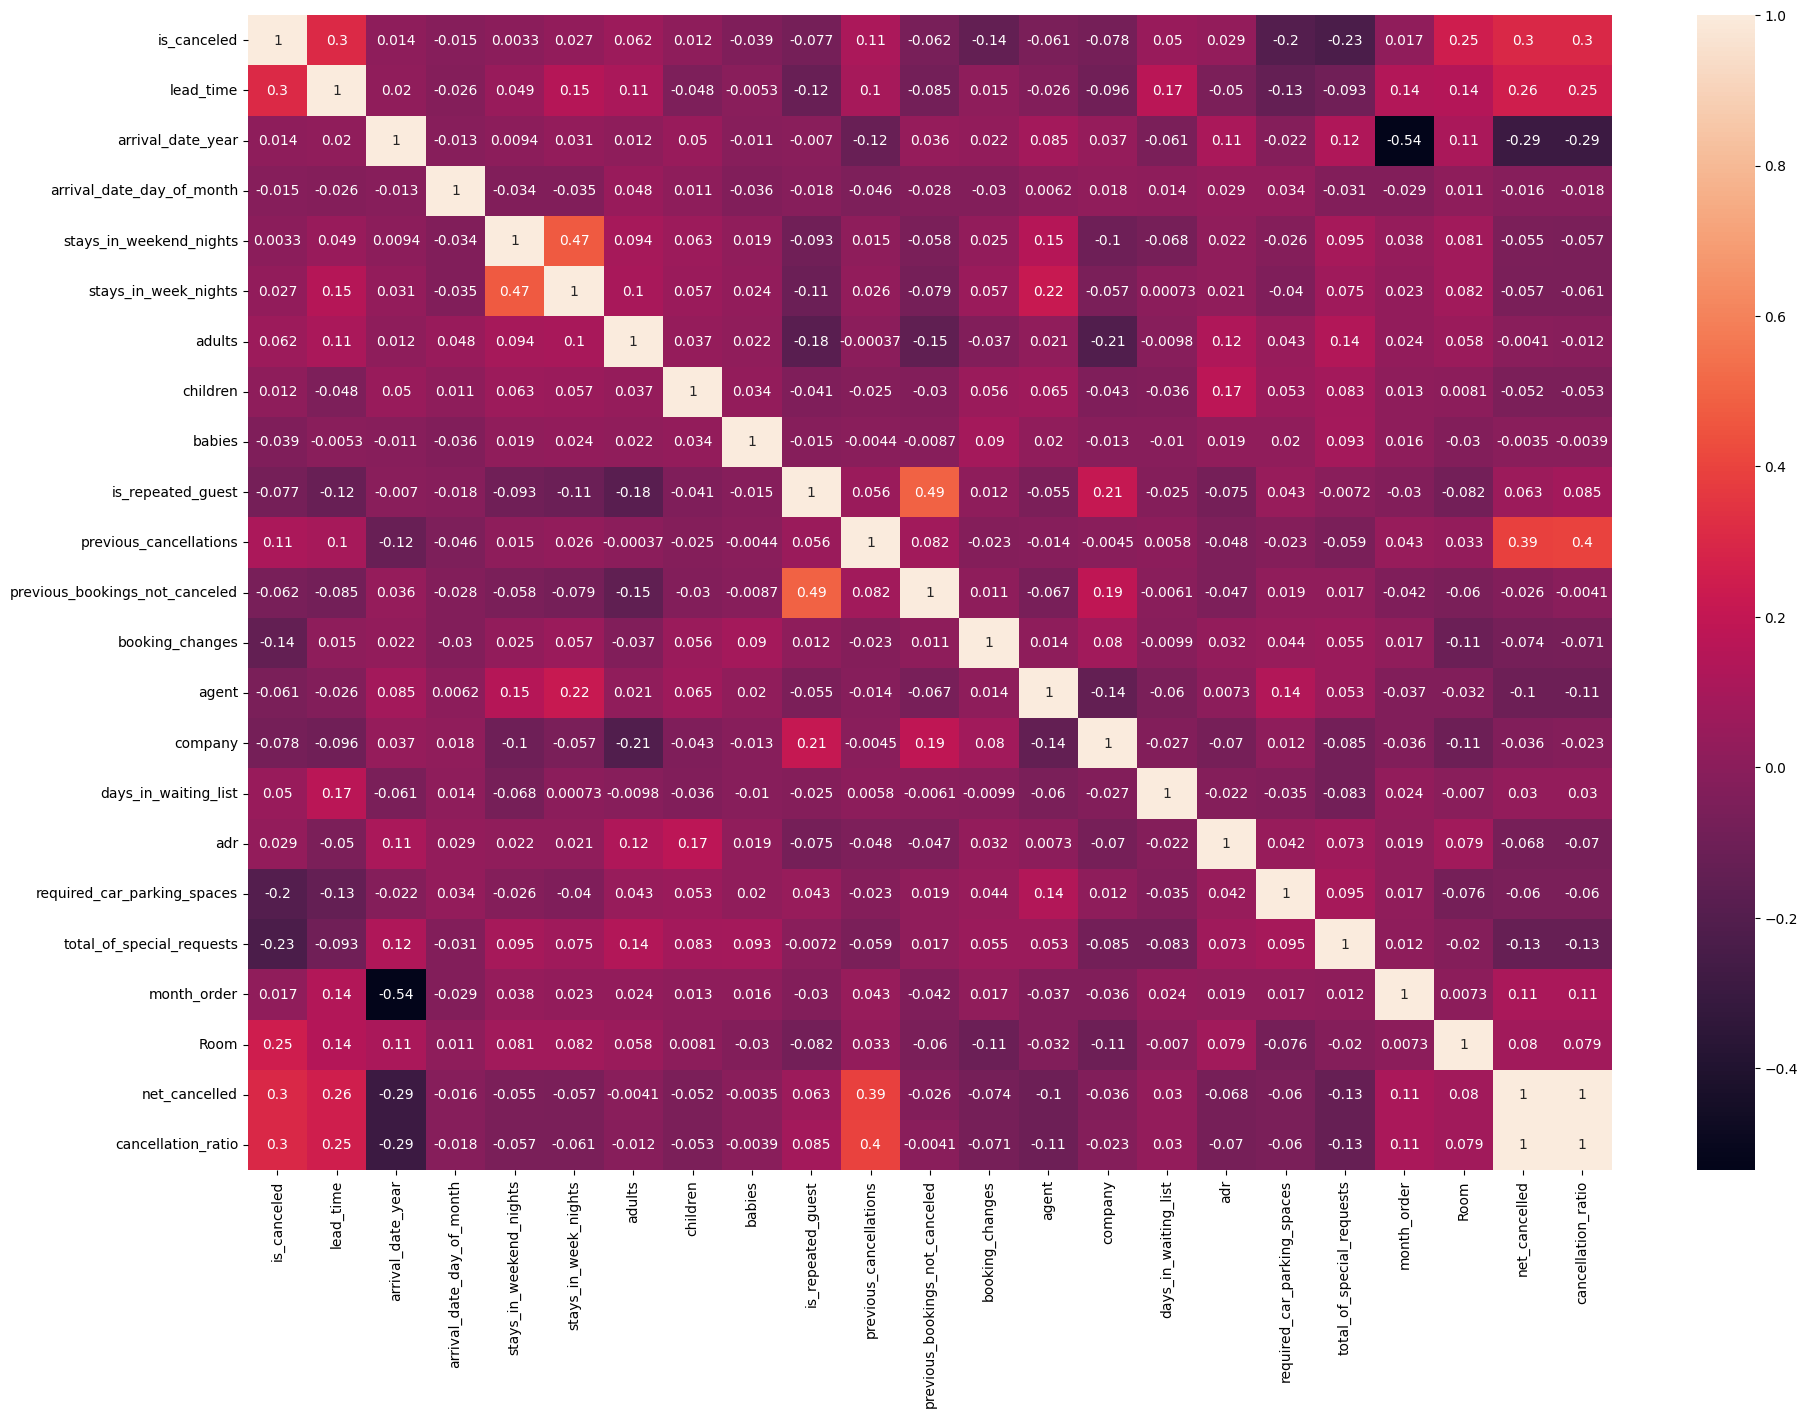

In [38]:
# Построим тепловую карту, чтобы увидеть корреляцию с колонками
fig, ax = plt.subplots(figsize=(22,15))
sns.heatmap(df_subset.corr(numeric_only=True), annot=True, ax=ax);

<hr>


Анализируя тепловую карту видим, что новая характеристика `cancellation_ratio` гораздо лучше коррелирует с `is_canceled` чем `previous_bookings_not_canceled` и `previous_cancellations`. В то же время видим, что корреляция между `cancellation_ratio` и `net_cancelled` составляет 1. Таким образом мы можем удалить все три показателя `cancellation_ratio`, `previous_cancellations` и `previous_bookings_not_canceled`, оставив только `net_cancelled`.

In [39]:
df_subset = df_subset.drop(['previous_cancellations','previous_bookings_not_canceled', 'cancellation_ratio'],axis=1)

Чтобы избежать переобучения модели удалим так же наименее значимые характеристики корреляция которых с `is_canceled` меньше 0,1

In [40]:
df_subset = df_subset.drop(['stays_in_week_nights', 'stays_in_weekend_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'agent','company', 'adr', 'days_in_waiting_list'],axis=1)

## Моделирование

### 1. Преобразование категориальных переменных в числовые

In [41]:
def transform(dataframe):
    le = LabelEncoder()
    
    # Выберем все категориальные признаки
    categorical_features = list(dataframe.columns[dataframe.dtypes == object])
    
    # Применим кодирование меток ко всем категориальным признакам
    return dataframe[categorical_features].apply(lambda x: le.fit_transform(x))

df = transform(df)

### 2. Разбиваем на обучающую и тестовую выборку

Для задачи предсказания отмены бронирования номеров в отеле мы будем использовать метод `train_test_split` для разделения данных на обучающую и тестовую выборки, поскольку он предоставляет следующие преимущества:


*   Независимость от временной структуры: В данной задаче временная структура данных может не иметь первостепенного значения, поскольку предсказание отмены бронирования скорее связано с характеристиками самого бронирования и клиентов, а не с их последовательностью во времени. Использование `train_test_split` обеспечивает случайное разделение данных, что позволяет получить обучающую и тестовую выборки, представляющие разнообразные примеры безотносительно времени

*   Предотвращение переобучения: `train_test_split` перемешивает данные перед разделением, что предотвращает возможное переобучение модели. Это гарантирует, что обучающая выборка содержит достаточно разнообразие, чтобы модель могла уловить основные закономерности, а тестовая выборка позволяет оценить обобщающую способность модели на новых данных.

*   Быстрота и простота: Использование `train_test_split` является простым и быстрым методом разделения данных, который обеспечивает хороший компромисс между эффективностью и точностью модели. Это позволяет сосредоточиться на самом процессе обучения и подборе оптимальных гиперпараметров, а также упрощает поддержку и внедрение модели в продуктивную среду.


Таким образом, использование `train_test_split` для разделения данных на обучающую и тестовую выборки обеспечивает эффективный и надежный способ для обучения и оценки модели предсказания отмены бронирования номеров в отеле. Этот метод обеспечивает хороший баланс между простотой, скоростью и точностью.

Заметим, что на практике нам будут известны только данные за прошедшие периоды и прогнозы мы должны строить опираясь на них. В этом случае в качестве обучающей выборки будем брать только данные из первой части набора данных, а в качестве тестовой - вторую часть, чтобы моделировать эту ситуацию.

In [42]:
def data_split(df, label, split_on=0):
    '''
    Разделим входной массив данных на обучающий и тестовый наборы и выполнить 
    одномоментное кодирование для категориальных переменных.

    Args:
        df (pandas.DataFrame): Входной фрейм данных.
        label (str): Имя столбца целевой метки.

    Returns:
        Кортеж из четырех элементов, содержащий обучающие и тестирующие признаки и метки.
    '''
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder

    X = df.drop(label, axis=1)
    Y = df[label]

    # Разделение на обучающее и тестирующее множества
    if split_on == 0: # Используем train_test_split с перемешиванием
      x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0)
    else: # Делим не перемешивая, а потом перемешиваем обучающую и тестовую выборки отдельно
      x_train = df_subset.iloc[:split_on].sample(frac=1)
      x_test = df_subset.iloc[split_on:].sample(frac=1)
      y_train = x_train.pop(label)
      y_test = x_test.pop(label)

    # Одномоментное кодирование категориальных переменных
    categorical_cols = X.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoder.fit(x_train[categorical_cols])
        x_train_encoded = encoder.transform(x_train[categorical_cols]).toarray()
        x_test_encoded = encoder.transform(x_test[categorical_cols]).toarray()
        x_train = x_train.drop(categorical_cols, axis=1)
        x_test = x_test.drop(categorical_cols, axis=1)
        x_train = np.hstack((x_train, x_train_encoded))
        x_test = np.hstack((x_test, x_test_encoded))

    return x_train, x_test, y_train, y_test

Проверим, что выборки корректно формируются при разбиении по дате. Для этого выберем самую позднюю дату из обучающей выборки и самую раннюю - из тестовой. Первая должна быть не больше второй.

In [43]:
label = 'is_canceled'
x_train = df_subset.iloc[:split_points[0]].sample(frac=1)
x_test = df_subset.iloc[split_points[0]:].sample(frac=1)
y_train = x_train.pop(label)
y_test = x_test.pop(label)

In [44]:
x_train.sort_values(by = ['arrival_date_year', 'month_order', 'arrival_date_day_of_month']  , axis=0, inplace=True)
x_train[['arrival_date_day_of_month','arrival_date_month','arrival_date_year']].tail(1)

,arrival_date_day_of_month,arrival_date_month,arrival_date_year
27628,2,September,2016


In [45]:
x_test.sort_values(by = ['arrival_date_year', 'month_order', 'arrival_date_day_of_month']  , axis=0, inplace=True)
x_test[['arrival_date_day_of_month','arrival_date_month','arrival_date_year']].head(1)

,arrival_date_day_of_month,arrival_date_month,arrival_date_year
56293,2,September,2016


Даты нам больше не нужны. Удалим их.

In [46]:
df_subset = df_subset.drop(['month_order','arrival_date_year','arrival_date_day_of_month','arrival_date_month'],axis=1)

### Модель машинного обучения

In [47]:
from sklearn.model_selection import GridSearchCV

def train(x_train, y_train, model_type='random_forest', random_state=0, estimators=[]):
    """
    Обучаем модели классификации на входных признаках и метках с помощью заданного алгоритма.

    Args:
        x_train (pandas.DataFrame): Фрейм данных, содержащий входные признаки.
        y_train (pandas.Series): Серия, содержащая целевые метки.
        x_test (pandas.DataFrame): Фрейм данных, содержащий входные признаки для тестирования.
        y_test (pandas.Series): Серия, содержащая целевые метки для тестирования.
        model_type (str): Тип используемой модели. Может быть 'random_forest',
        'voting_classifier', 'logistic_regression' или 'SVM'. По умолчанию - 'random_forest'.
        random_state (int): Случайное зерно, используемое для воспроизводимости. По умолчанию 0.

    Returns:
        Обученный объект модели scikit-learn или CatBoost.
    """
    if model_type == 'random_forest':
        model = RandomForestClassifier(random_state=random_state)
    elif model_type == 'voting_classifier':
        model = VotingClassifier(estimators=estimators, voting='soft')
    elif model_type == 'logistic_regression':
        model = LogisticRegression(solver='newton-cholesky', max_iter=500)
    elif model_type == 'SVM':
        model = SVC(kernel='rbf', C=15000, gamma='scale', probability=True)
    else:
        raise ValueError(f"Неверный тип модели: {model_type}")

    model.fit(x_train, y_train)

    return model

### 4. Оценка модели

In [48]:
def Score(clf, x_train, y_train, x_test, y_test):
    # Вычислим точность обучения и тестирования
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)

    # Вычислим тренировочную и тестовую ROC-кривую и AUC
    train_probs = clf.predict_proba(x_train)[:, 1]
    test_probs = clf.predict_proba(x_test)[:, 1]
    train_fpr, train_tpr, _ = roc_curve(y_train, train_probs)
    test_fpr, test_tpr, _ = roc_curve(y_test, test_probs)
    train_auc = roc_auc_score(y_train, train_probs)
    test_auc = roc_auc_score(y_test, test_probs)

    # Вывод оценок и построение ROC-кривых
    print("========================================")
    print(f'Точность на обучающей выборке: {train_score}')
    print(f'Точность на тестовой выборке: {test_score}')
    print(f'Training AUC нашей модели: {train_auc}')
    print(f'Testing AUC нашей модели: {test_auc}')
    print("========================================")

### Обучим CatBoost

In [49]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [51]:
def data_split_cat(df, label, split_on=[]):
    '''
    Разделим входной массив данных на обучающий, тестовый и валидационный наборы.

    Args:
        df (pandas.DataFrame): Входной фрейм данных.
        label (str): Имя столбца целевой метки.

    Returns:
        Кортеж из шести элементов, содержащий обучающие, тестовые и валидационные признаки и метки.
    '''
    from sklearn.model_selection import train_test_split

    X = df.drop(label, axis=1)
    Y = df[label]

    if split_on == []:
      # Разделение на тренировочное и тестовое множества
      x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
      # Разделение на тренировочное и валидационное множества
      x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
    else:
      x_train = df_subset.iloc[:split_on[0]].sample(frac=1)
      x_test = df_subset.iloc[split_on[0]:split_on[1]].sample(frac=1)
      x_val = df_subset.iloc[split_on[1]:].sample(frac=1)
      y_train = x_train.pop(label)
      y_test = x_test.pop(label)      
      y_val = x_val.pop(label)

    return x_train, x_test, x_val, y_train, y_test, y_val

In [52]:
# Разделение на тренировочное, тестовое и валидационное множества
x_trains, x_tests, x_vals, y_trains, y_tests, y_vals = data_split_cat(df_subset, 'is_canceled')

In [53]:
# Указание категориальных признаков
cat_features = ['hotel', 'meal', 'country_group', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type']

# Создание и обучение модели CatBoost
clf5 = CatBoostClassifier(loss_function='Logloss', random_seed=0)
clf5.fit(x_trains, y_trains, eval_set=(x_vals, y_vals), cat_features=cat_features, verbose=100)

# Оценка качества модели на тестовом множестве
test_score = clf5.score(x_tests, y_tests)
print(f'Test score: {test_score:.3f}')

Learning rate set to 0.039956
0:	learn: 0.6724038	test: 0.6725518	best: 0.6725518 (0)	total: 78ms	remaining: 1m 17s
100:	learn: 0.3140354	test: 0.3393496	best: 0.3393496 (100)	total: 1.75s	remaining: 15.6s
200:	learn: 0.2905946	test: 0.3296593	best: 0.3296012 (196)	total: 2.57s	remaining: 10.2s
300:	learn: 0.2696224	test: 0.3282209	best: 0.3281461 (298)	total: 3.98s	remaining: 9.26s
400:	learn: 0.2555400	test: 0.3262002	best: 0.3261663 (397)	total: 4.84s	remaining: 7.23s
500:	learn: 0.2412381	test: 0.3256936	best: 0.3248958 (469)	total: 5.75s	remaining: 5.73s
600:	learn: 0.2282983	test: 0.3256109	best: 0.3248958 (469)	total: 7.67s	remaining: 5.09s
700:	learn: 0.2186150	test: 0.3272101	best: 0.3248958 (469)	total: 9.89s	remaining: 4.22s
800:	learn: 0.2089944	test: 0.3281535	best: 0.3248958 (469)	total: 13.4s	remaining: 3.33s
900:	learn: 0.1987412	test: 0.3284363	best: 0.3248958 (469)	total: 16.1s	remaining: 1.77s
999:	learn: 0.1889166	test: 0.3293385	best: 0.3248958 (469)	total: 18.3s	r

In [54]:
Score(clf5,x_trains,y_trains, x_tests, y_tests)

Точность на обучающей выборке: 0.8810641627543035
Точность на тестовой выборке: 0.8310387984981227
Training AUC нашей модели: 0.9505397393590246
Testing AUC нашей модели: 0.9176658280263124


Повторим моделирование для ситуации, где известны только данные за прошедшие периоды.

In [55]:
x_trains2, x_tests2, x_vals2, y_trains2, y_tests2, y_vals2 = data_split_cat(df_subset, 'is_canceled', split_points)
clf5_ = CatBoostClassifier(loss_function='Logloss', random_seed=0)
clf5_.fit(x_trains2, y_trains2, eval_set=(x_vals2, y_vals2), cat_features=cat_features, verbose=100)
test_score = clf5_.score(x_tests2, y_tests2)
print(f'Test score: {test_score:.3f}')

Learning rate set to 0.037607
0:	learn: 0.6624015	test: 0.6769565	best: 0.6769565 (0)	total: 19.8ms	remaining: 19.7s
100:	learn: 0.2661452	test: 0.4699668	best: 0.4699668 (100)	total: 1.47s	remaining: 13.1s
200:	learn: 0.2392119	test: 0.4715944	best: 0.4692064 (117)	total: 2.46s	remaining: 9.8s
300:	learn: 0.2198868	test: 0.4739150	best: 0.4692064 (117)	total: 3.22s	remaining: 7.48s
400:	learn: 0.2038079	test: 0.4798404	best: 0.4692064 (117)	total: 4.17s	remaining: 6.22s
500:	learn: 0.1904767	test: 0.4860078	best: 0.4692064 (117)	total: 5.14s	remaining: 5.12s
600:	learn: 0.1766813	test: 0.4949408	best: 0.4692064 (117)	total: 6.04s	remaining: 4.01s
700:	learn: 0.1645217	test: 0.5076302	best: 0.4692064 (117)	total: 8.73s	remaining: 3.72s
800:	learn: 0.1547153	test: 0.5133954	best: 0.4692064 (117)	total: 11.4s	remaining: 2.84s
900:	learn: 0.1462712	test: 0.5212851	best: 0.4692064 (117)	total: 13.4s	remaining: 1.48s
999:	learn: 0.1387761	test: 0.5315119	best: 0.4692064 (117)	total: 15.9s	r

### Обучим случайный лес

In [56]:
# Разделение на тренировочное, тестовое и валидационное множества
x_train, x_test, y_train, y_test = data_split(df_subset, 'is_canceled')

In [57]:
clf2 = train(x_train, y_train, model_type='random_forest')

In [58]:
Score(clf2,x_train, y_train, x_test, y_test)

Точность на обучающей выборке: 0.9843071786310518
Точность на тестовой выборке: 0.8158158158158159
Training AUC нашей модели: 0.9986545668784016
Testing AUC нашей модели: 0.8818891836133216


То же самое для неизвестных будущих периодов.

In [59]:
# Разделение на тренировочное, тестовое и валидационное множества
x_train2, x_test2, y_train2, y_test2 = data_split(df_subset, 'is_canceled', split_points[0])

In [60]:
clf2_ = train(x_train2, y_train2, model_type='random_forest')
Score(clf2_, x_train2, y_train2, x_test2, y_test2)

Точность на обучающей выборке: 0.989
Точность на тестовой выборке: 0.7838515546639919
Training AUC нашей модели: 0.9993334976313699
Testing AUC нашей модели: 0.8351051377005918


### Обучим Логистическую регрессию

In [61]:
def LogReport(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

    report = classification_report(y_test, y_pred)
    print(report)

In [62]:
clf_log = train(x_train, y_train, model_type='logistic_regression')

Accuracy: 80.88%
Confusion matrix:
 [[573  36]
 [155 235]]


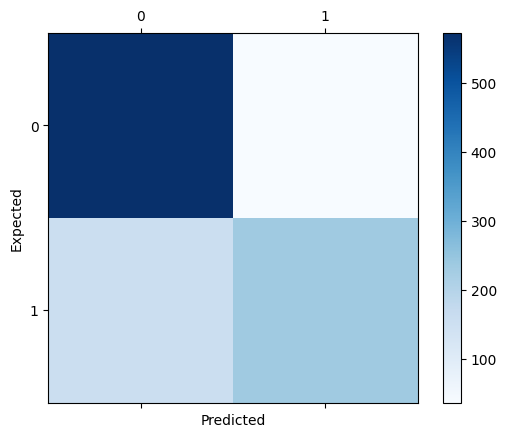

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       609
           1       0.87      0.60      0.71       390

    accuracy                           0.81       999
   macro avg       0.83      0.77      0.78       999
weighted avg       0.82      0.81      0.80       999



In [63]:
LogReport(clf_log, x_test, y_test)

То же самое для неизвестных будущих периодов.

In [64]:
clf_log_ = train(x_train2, y_train2, model_type='logistic_regression')

Accuracy: 76.68%
Confusion matrix:
 [[1179   51]
 [ 414  350]]


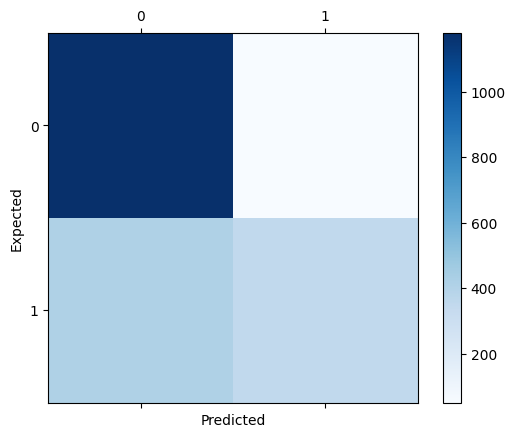

              precision    recall  f1-score   support

           0       0.74      0.96      0.84      1230
           1       0.87      0.46      0.60       764

    accuracy                           0.77      1994
   macro avg       0.81      0.71      0.72      1994
weighted avg       0.79      0.77      0.75      1994



In [65]:
LogReport(clf_log_, x_test2, y_test2)

### Обучим SVM

In [66]:
clf_SVM = train(x_train, y_train, model_type='SVM')

Accuracy: 81.28%
Confusion matrix:
 [[560  49]
 [138 252]]


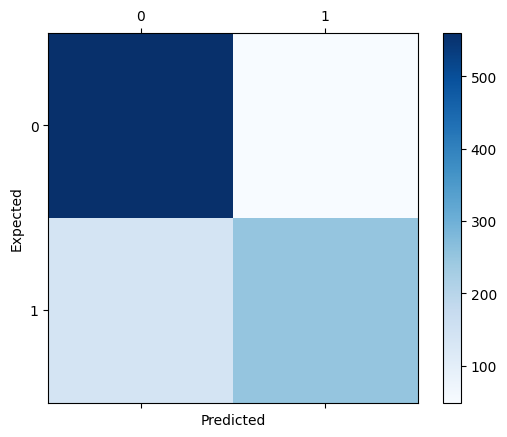

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       609
           1       0.84      0.65      0.73       390

    accuracy                           0.81       999
   macro avg       0.82      0.78      0.79       999
weighted avg       0.82      0.81      0.81       999



In [67]:
LogReport(clf_SVM, x_test, y_test)

То же самое для неизвестных будущих периодов.

In [68]:
clf_SVM_ = train(x_train2, y_train2, model_type='SVM')

Accuracy: 76.93%
Confusion matrix:
 [[1165   65]
 [ 395  369]]


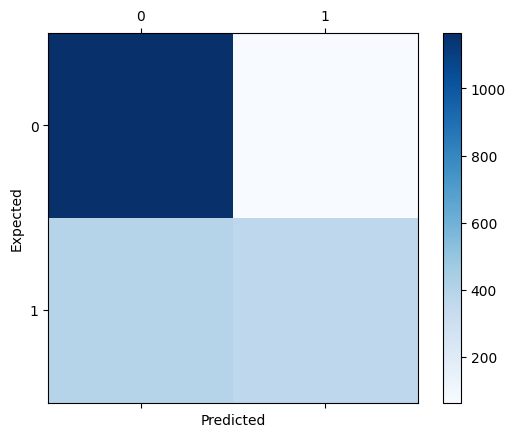

              precision    recall  f1-score   support

           0       0.75      0.95      0.84      1230
           1       0.85      0.48      0.62       764

    accuracy                           0.77      1994
   macro avg       0.80      0.72      0.73      1994
weighted avg       0.79      0.77      0.75      1994



In [69]:
LogReport(clf_SVM_, x_test2, y_test2)

### Обучим Voting classifier

In [70]:
clf4 = train(x_train, y_train, model_type='voting_classifier', estimators=[('lrc', clf_log), ('rfc', clf2), ('svc', clf_SVM)])

In [71]:
def ScoreVoting(clf, x_train, y_train, x_test, y_test):
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)
    
    try:
        train_probs = clf.predict_proba(x_train)[:, 1]
        test_probs = clf.predict_proba(x_test)[:, 1]
        train_auc = roc_auc_score(y_train, train_probs)
        test_auc = roc_auc_score(y_test, test_probs)
    except AttributeError:
        # Если predict_proba недоступна, рассчитаем оценку AUC на основе предсказанных классов
        train_pred = clf.predict(x_train)
        test_pred = clf.predict(x_test)
        train_probs = (train_pred == 1).astype(float)
        test_probs = (test_pred == 1).astype(float)
        train_auc = roc_auc_score(y_train, train_probs)
        test_auc = roc_auc_score(y_test, test_probs)

    print("========================================")
    print(f"Оценка точности обучения: {train_score:.4f}")
    print(f"Оценка AUC при обучении: {train_auc:.4f}")
    print("========================================")
    print(f"Точность теста: {test_score:.4f}")
    print(f"Оценка AUC теста: {test_auc:.4f}")
    print("========================================")


In [72]:
ScoreVoting(clf4,x_train, y_train, x_test, y_test)

Оценка точности обучения: 0.8985
Оценка AUC при обучении: 0.9784
Точность теста: 0.8178
Оценка AUC теста: 0.9113


То же самое для неизвестных будущих периодов.

In [73]:
clf4_ = train(x_train2, y_train2, model_type='voting_classifier', estimators=[('lrc', clf_log_), ('rfc', clf2_), ('svc', clf_SVM_)])
ScoreVoting(clf4_, x_train2, y_train2, x_test2, y_test2)

Оценка точности обучения: 0.9195
Оценка AUC при обучении: 0.9867
Точность теста: 0.7859
Оценка AUC теста: 0.8616


### Построим графики ROC

In [74]:
def plotROC(classifiers, x_test, y_test):
  roc_data = {}

  for name, clf in classifiers.items():
      try:
          if name == 'Linear Regression':
              probs = clf.predict(x_test)
          else:
              probs = clf.predict_proba(x_test)[:, 1]
      except AttributeError:
          pred = clf.predict(x_test)
          probs = (pred == 1).astype(float)
      
      fpr, tpr, _ = roc_curve(y_test, probs)
      auc = roc_auc_score(y_test, probs)
      roc_data[name] = (fpr, tpr, auc)

  plt.figure(figsize=(10, 8))

  for name, data in roc_data.items():
      if name != 'CatBoost': # исключаем модель CatBoost
          plt.plot(data[0], data[1], label=f"{name} (AUC = {data[2]:.3f})")

  plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curves for Different Models")
  plt.legend()
  plt.show()

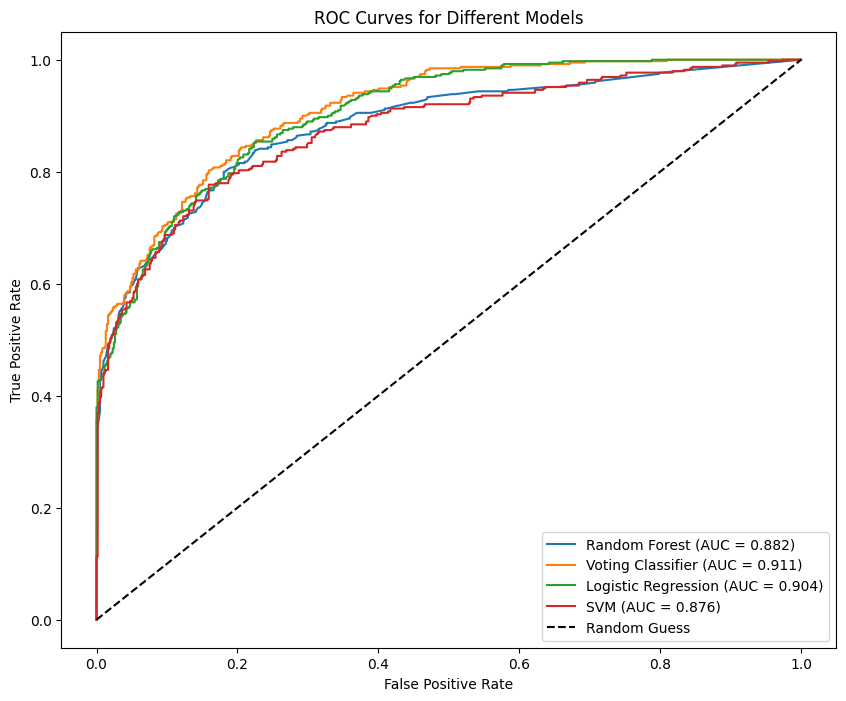

In [75]:
classifiers = {'Random Forest': clf2, 'Voting Classifier': clf4, 'Logistic Regression': clf_log, 'SVM': clf_SVM}
plotROC(classifiers, x_test, y_test)

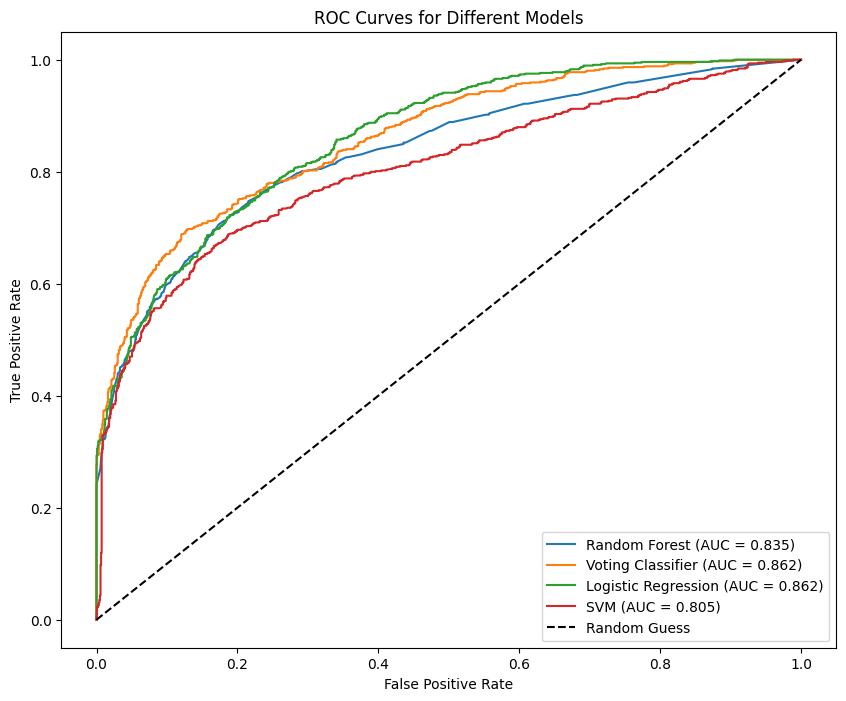

In [76]:
classifiers = {'Random Forest': clf2_, 'Voting Classifier': clf4_, 'Logistic Regression': clf_log_, 'SVM': clf_SVM_}
plotROC(classifiers, x_test2, y_test2)

In [77]:
def predict(clf, x):
    return clf.predict(np.array(x).reshape(1, -1))[0]

In [78]:
# Делаем прогноз для конкретной записи в обучающем множестве
x = x_train[10]
prediction = predict(clf2, x) # Сделаем предсказание, используя обученный классификатор
actual_value = y_train.iloc[10]

print(f'Прогнозируемое значение: {prediction}')
print(f'Фактическое значение: {actual_value}')

Прогнозируемое значение: 0
Фактическое значение: 0
